In [63]:
import numpy

In [ ]:
!pip install scikit-learn==1.5.2
!pip install keras==3.3.3
!pip install tensorflow==2.16.1

In [ ]:
import sklearn
import keras
import tensorflow as tf

print(f"Sklearn version: {sklearn.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")

In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
SR=22050
N_MFCC=40
N_MELS=128
DURATION=1
SAMPLES_PER_TRACK=SR*DURATION
CLASSES=['AR','nogun','Sniper']

In [3]:
dataset=pd.read_csv('dataset1.csv')

In [4]:
def extract_features(file_path):
    y,sr=librosa.load(file_path,sr=SR,duration=DURATION)
    if len(y)<SAMPLES_PER_TRACK:
        y=np.pad(y,(0,SAMPLES_PER_TRACK-len(y)))
    else:
        y=y[:SAMPLES_PER_TRACK]
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=N_MFCC)
    mfcc=librosa.util.fix_length(mfcc,size=174,axis=1)
    mfcc=mfcc[...,np.newaxis]

    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr)
    mel_spec=librosa.power_to_db(mel_spec,ref=np.max)
    mel_spec=librosa.util.fix_length(mel_spec,size=174,axis=1)
    mel_spec=mel_spec[...,np.newaxis]
    return mfcc,mel_spec

In [5]:
def load_dataset(dataset_path):
    x_mfcc,x_melspec,gun_type,direction,distance=[],[],[],[],[]
    suffixes=['_gain.wav','_pan.wav','_pitch.wav','_reverse.wav','_speed.wav','_noise.wav','_original.wav']
    for i,class_name in enumerate(CLASSES):
        class_dir=os.path.join(dataset_path,class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path=os.path.join(class_dir,file_name)
                mfcc,mel_spec=extract_features(file_path)
                x_mfcc.append(mfcc)
                x_melspec.append(mel_spec)
                if class_name=='Sniper':
                    for suffix in suffixes:
                        if file_name.endswith(suffix):
                            file_name=file_name[:-len(suffix)]+'.wav'
                gun_type.append(i)
                if class_name=='nogun':
                    direction.append('None')
                    distance.append('None')
                else:
                    row=dataset[dataset['name']==file_name]
                    direction.append(row['dire'].values[0])
                    distance.append(row['dist'].values[0])
    x_mfcc=np.array(x_mfcc)
    x_melspec=np.array(x_melspec)
    gun_encoder=LabelEncoder()
    gun_types_encoded=gun_encoder.fit_transform(gun_type)
    gun_types_categorical=to_categorical(gun_types_encoded)
    gun_types_categorical=np.array(gun_types_categorical)

    direction_encoder=LabelEncoder()
    direction_encoder.classes_ = np.array(['None', 'back', 'center', 'front', 'left', 'right'])
    direction_types_encoded=direction_encoder.fit_transform(direction)
    direction_types_categorical=to_categorical(direction_types_encoded)
    direction_types_categorical=np.array(direction_types_categorical)

    distance_encoder=LabelEncoder()
    distance_encoder.classes_ = np.array(['0m', '100m', '200m', '400m', '50m', '600m','None'])
    distance_types_encoded=distance_encoder.fit_transform(distance)
    distance_types_categorical=to_categorical(distance_types_encoded)
    distance_types_categorical=np.array(distance_types_categorical)
    return x_mfcc,x_melspec,gun_types_categorical,direction_types_categorical,distance_types_categorical


In [6]:
X_mfcc,X_melspec,y_gun,y_direction,y_distance=load_dataset('gun_sound_v9')

In [7]:
X_melspec_shape=X_melspec.shape
X_melspec_shape

(2807, 128, 174, 1)

In [8]:
X_mfcc_shape=X_mfcc.shape
X_mfcc_shape

(2807, 40, 174, 1)

In [9]:
y_gun.shape

(2807, 3)

In [10]:
y_direction.shape

(2807, 6)

In [11]:
#X_mfcc_trainval, X_mfcc_test, X_melspec_trainval, X_melspec_test, y_gun_trainval, y_gun_test,y_distance_trainval,y_distance_test,y_direction_trainval,y_direction_test = train_test_split(
#    X_mfcc, X_melspec, y_gun,y_distance,y_direction,test_size=0.3, random_state=42
#)

# Then, split the training+validation set into training and validation sets
X_mfcc_train, X_mfcc_val, X_melspec_train, X_melspec_val, y_gun_train, y_gun_val,y_distance_train,y_distance_val,y_direction_train,y_direction_val = train_test_split(
     X_mfcc, X_melspec, y_gun,y_distance,y_direction, test_size=0.2, random_state=42
 )

In [12]:
y_gun_train=np.array(y_gun_train)
y_gun_train.shape

(2245, 3)

In [13]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Input
from tensorflow.keras.models import Model
def create_model(input_shape_mfcc,input_shape_melspec,num_classes=3,num_directions=6,num_distances=7):
    input_mfcc=Input(shape=input_shape_mfcc,name='mfcc_input')
    x_mfcc=Conv2D(16,kernel_size=(3,3),activation='relu')(input_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(32,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(64,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(1,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(128,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=GlobalAveragePooling2D()(x_mfcc)

    input_melspec=Input(shape=input_shape_melspec,name='melspec_input')
    x_melspec=Conv2D(16,kernel_size=(3,3),activation='relu')(input_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(32,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(64,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(128,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec = GlobalAveragePooling2D()(x_melspec)

    concatenated=tf.keras.layers.concatenate([x_mfcc,x_melspec])
    common_dense=Dense(128,activation='relu',name='concatenated')(concatenated)
    gunshot_output=Dense(num_classes,activation='softmax',name='gunshot_output')(common_dense)
    direction_output=Dense(num_directions,activation='softmax',name='direction_output')(common_dense)
    distance_output=Dense(num_distances,activation='softmax',name='distance_output')(common_dense)

    model=Model(inputs=[input_mfcc,input_melspec],outputs=[gunshot_output,direction_output,distance_output])

    return model

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

def create_feature_extractor(input_shape_mfcc, input_shape_melspec):
    model = create_model(input_shape_mfcc, input_shape_melspec)
    feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer('concatenated').output)
    return model,feature_extractor

In [15]:
input_shape_mfcc=(40,174,1)
input_shape_melspec=(128,174,1)
model,feature_extractor=create_feature_extractor(input_shape_mfcc,input_shape_melspec)

In [16]:
model.compile(optimizer='adam',
              loss={
                    'gunshot_output':'categorical_crossentropy',
                    'direction_output':'categorical_crossentropy',
                    'distance_output':'categorical_crossentropy'},
                metrics={
                    'gunshot_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'distance_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'direction_output': ['accuracy', 'Precision', 'Recall', AUC()]
                    })


In [17]:
from keras.callbacks import ModelCheckpoint
batch_size=32
valid_batch_size=32
callbacks=[ModelCheckpoint("best_model.keras",monitor='val_loss')]
history=model.fit([X_mfcc_train,X_melspec_train],
                  {
                      'gunshot_output':y_gun_train,
                      'direction_output':y_direction_train,
                      'distance_output':y_distance_train
                  },
                  validation_data=([X_mfcc_val,X_melspec_val],
                                    {
                                        'gunshot_output':y_gun_val,
                                        'direction_output':y_direction_val,
                                        'distance_output':y_distance_val
                                    }),
                    epochs=70,batch_size=32,callbacks=[callbacks])


Epoch 1/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - direction_output_Precision: 0.3162 - direction_output_Recall: 0.0514 - direction_output_accuracy: 0.2464 - direction_output_auc_2: 0.5778 - distance_output_Precision: 0.2956 - distance_output_Recall: 0.0222 - distance_output_accuracy: 0.1991 - distance_output_auc_1: 0.5701 - gunshot_output_Precision: 0.5267 - gunshot_output_Recall: 0.2879 - gunshot_output_accuracy: 0.5234 - gunshot_output_auc: 0.6662 - loss: 5.4571 - val_direction_output_Precision: 0.8611 - val_direction_output_Recall: 0.1103 - val_direction_output_accuracy: 0.3434 - val_direction_output_auc_2: 0.7274 - val_distance_output_Precision: 0.9153 - val_distance_output_Recall: 0.0961 - val_distance_output_accuracy: 0.3274 - val_distance_output_auc_1: 0.7478 - val_gunshot_output_Precision: 0.9320 - val_gunshot_output_Recall: 0.2438 - val_gunshot_output_accuracy: 0.7491 - val_gunshot_output_auc: 0.8807 - val_loss: 3.9751
Epoch 2/70
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 333ms/step 

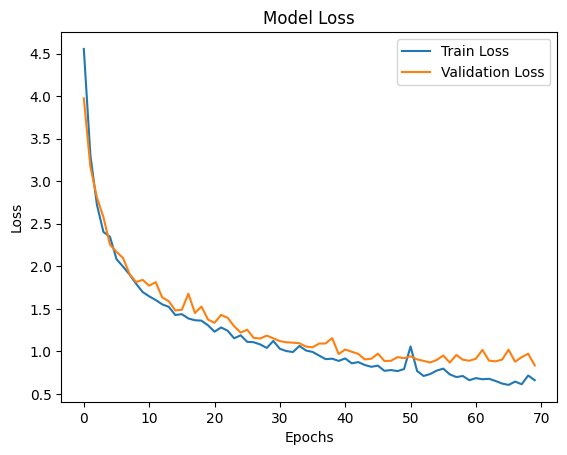

In [18]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Plot overall train and validation loss"
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [19]:
features=feature_extractor.predict([X_mfcc,X_melspec])

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step


In [21]:
# layer_name='concatenated'
# intermediate_layer_model=Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
# intermediate_layer_model.summary()

In [20]:
features.shape

(2807, 128)

In [21]:
y_gun.shape

(2807, 3)

In [42]:
y_combined = np.column_stack((y_gun, y_direction, y_distance))
X_train,X_test,y_train_combined,y_test_combined=train_test_split(features,y_combined,test_size=0.3)
y_gun_train = y_train_combined[:, [0,1,2]]
y_dir_train = y_train_combined[:, [3,4,5,6,7,8]]
y_dist_train = y_train_combined[:, [9,10,11,12,13,14,15]]

y_gun_test = y_test_combined[:, [0,1,2]]
y_dir_test = y_test_combined[:, [3,4,5,6,7,8]]
y_dist_test = y_test_combined[:, [9,10,11,12,13,14,15]]

In [43]:
y_gun_train.shape

(1964, 3)

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def objective_function_gun(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  
        eval_metric='mlogloss'    
    )
    cv_score = cross_val_score(model, X_train_scaled, y_gun_train, cv=kf, scoring="accuracy")
    return -cv_score.mean()  


def objective_function_dir(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  
        eval_metric='mlogloss'    
    )
    cv_score = cross_val_score(model, X_train_scaled, y_dir_train, cv=kf, scoring="accuracy")
    return -cv_score.mean() 


def objective_function_dist(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  
        eval_metric='mlogloss'    
    )
    cv_score = cross_val_score(model, X_train_scaled, y_dist_train, cv=kf, scoring="accuracy")
    return -cv_score.mean()  


In [45]:
param_ranges = {
    'n_estimators': (50, 500),
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 10)
}


In [55]:
import cupy as cp

def initialize_population(pop_size, param_ranges):
    population = []
    for _ in range(pop_size):
        individual = [
            cp.random.randint(*param_ranges['n_estimators']),
            cp.random.randint(*param_ranges['max_depth']),
            cp.random.uniform(*param_ranges['learning_rate']),
            cp.random.uniform(*param_ranges['subsample']),
            cp.random.uniform(*param_ranges['colsample_bytree']),
            cp.random.uniform(*param_ranges['gamma']),
        ]
        population.append(individual)
    return cp.array(population)

def crossover(parent1, parent2, crossover_rate=0.5):
    if cp.random.rand() < crossover_rate:
        crossover_point = cp.random.randint(1, len(parent1) - 1)
        child1 = cp.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = cp.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2

def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if cp.random.rand() < mutation_rate:  
            min_val, max_val = param_ranges[list(param_ranges.keys())[i]]
            individual[i] = cp.random.uniform(min_val, max_val) if isinstance(min_val, float) else cp.random.randint(min_val, max_val)
    return individual

def selection(population, fitness, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament_indices = cp.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = fitness[tournament_indices]
        best_index = tournament_indices[cp.argmin(tournament_fitness)]
        selected.append(population[best_index])
    return cp.array(selected)

def genetic_algorithm_gun(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = cp.array([objective_function_gun(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = cp.array(next_gen)
    best_individual = population[cp.argmin(cp.array([objective_function_gun(ind) for ind in population]))]
    return best_individual

def genetic_algorithm_dir(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = cp.array([objective_function_dir(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = cp.array(next_gen)
    best_individual = population[cp.argmin(cp.array([objective_function_dir(ind) for ind in population]))]
    return best_individual

def genetic_algorithm_dist(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = cp.array([objective_function_dist(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = cp.array(next_gen)
    best_individual = population[cp.argmin(cp.array([objective_function_dist(ind) for ind in population]))]
    return best_individual


In [70]:
import xgboost as xgb

ans_gun=genetic_algorithm_gun(6,10)
xgb_model_gun = xgb.XGBClassifier(
    n_estimators=int(ans_gun[0]),
    max_depth=int(ans_gun[1]),
    learning_rate=ans_gun[2],
    subsample=ans_gun[3],
    colsample_bytree=ans_gun[4],
    gamma=ans_gun[5],
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
)
xgb_model_gun.fit(X_train,y_gun_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

KeyboardInterrupt: 

In [53]:
ans_dir=genetic_algorithm_dir(20,20)
xgb_model_direction = xgb.XGBClassifier(
        n_estimators=int(ans_dir[0]),
        max_depth=int(ans_dir[1]),
        learning_rate=ans_dir[2],
        subsample=ans_dir[3],
        colsample_bytree=ans_dir[4],
        gamma=ans_dir[5],
        use_label_encoder=False,  
        eval_metric='mlogloss',
         
    )
xgb_model_direction.fit(X_train, y_dir_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:11:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

KeyboardInterrupt: 

In [50]:
ans_dist=genetic_algorithm_dist(6,10)
xgb_model_distance = xgb.XGBClassifier(
        n_estimators=int(ans_dist[0]),
        max_depth=int(ans_dist[1]),
        learning_rate=ans_dist[2],
        subsample=ans_dist[3],
        colsample_bytree=ans_dist[4],
        gamma=ans_dist[5],
        use_label_encoder=False,  
        eval_metric='mlogloss',    
    )
xgb_model_distance.fit(X_train, y_dist_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7268741650473234, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=1.5704721133273236, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.23829750718921028,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=340, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_gun[0]}")
print(f"max_depth: {ans_gun[1]}")
print(f"learning_rate: {ans_gun[2]}")
print(f"subsample: {ans_gun[3]}")
print(f"colsample_bytree: {ans_gun[4]}")
print(f"gamma: {ans_gun[5]}")


In [ ]:
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_dir[0]}")
print(f"max_depth: {ans_dir[1]}")
print(f"learning_rate: {ans_dir[2]}")
print(f"subsample: {ans_dir[3]}")
print(f"colsample_bytree: {ans_dir[4]}")
print(f"gamma: {ans_dir[5]}")

In [ ]:
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_dist[0]}")
print(f"max_depth: {ans_dist[1]}")
print(f"learning_rate: {ans_dist[2]}")
print(f"subsample: {ans_dist[3]}")
print(f"colsample_bytree: {ans_dist[4]}")
print(f"gamma: {ans_dist[5]}")

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot XGBoost feature importance (top 50 features)
xgb.plot_importance(xgb_model_gun, max_num_features=10, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()


In [ ]:
import pandas as pd
feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
print(X_train_df.head())


In [ ]:
import shap
print(shap.__version__)


In [ ]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: XGBoost Feature Importance (Top 10 features)
# Plot the top 10 most important features using XGBoost's built-in feature importance
xgb.plot_importance(xgb_model_gun, max_num_features=10, importance_type='weight')
plt.title('Top 10 XGBoost Feature Importance')
plt.show()

# Step 2: SHAP Summary Plot for the top 10 features
# Get SHAP values for the gun model
explainer_gun = shap.TreeExplainer(xgb_model_gun)
shap_values_gun = explainer_gun(X_train_df)

# Calculate the mean absolute SHAP values for each feature
shap_values_gun_df = pd.DataFrame(shap_values_gun, columns=X_train_df.columns)

# Get the top 10 most important features based on the mean absolute SHAP values
mean_abs_shap = shap_values_gun_df.abs().mean(axis=0).sort_values(ascending=False)
top_10_features = mean_abs_shap.head(10).index

# Create the SHAP summary plot for the top 10 features
shap.summary_plot(shap_values_gun[:, top_10_features], X_train_df[top_10_features])


In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Get SHAP values for the model
shap_values_gun_df = pd.DataFrame(shap_values_gun, columns=X_train_df.columns)

# Calculate mean absolute SHAP values and sort by importance
mean_abs_shap = shap_values_gun_df.abs().mean(axis=0).sort_values(ascending=False)

# Select top 20 most important features
top_20_features = mean_abs_shap.head(20).index

# Plot SHAP summary plot for these top 20 features
shap.summary_plot(shap_values_gun[:, top_20_features], X_train_df[top_20_features])


In [51]:
gun_type_trainpred=xgb_model_gun.predict(X_test)
direction_type_trainpred = xgb_model_direction.predict(X_test)
distance_type_trainpred = xgb_model_distance.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy for gun type
gun_accuracy = accuracy_score(y_gun_test, gun_type_trainpred)
print(f"Accuracy for gun type classification: {gun_accuracy * 100:.2f}%")

# Evaluate accuracy for direction type
direction_accuracy = accuracy_score(y_dir_test, direction_type_trainpred)
print(f"Accuracy for direction type classification: {direction_accuracy * 100:.2f}%")

# Evaluate accuracy for distance type
distance_accuracy = accuracy_score(y_dist_test, distance_type_trainpred)
print(f"Accuracy for distance type classification: {distance_accuracy * 100:.2f}%")


Accuracy for gun type classification: 98.46%
Accuracy for direction type classification: 81.02%
Accuracy for distance type classification: 93.95%


In [ ]:
dataset_test= pd.read_csv('/content/drive/MyDrive/dataset4.csv')
dataset_test.drop_duplicates(inplace=True)

In [ ]:
dataset_test

In [ ]:
def load_test_dataset(dataset_path, dataset):
    x_mfcc, x_melspec, gun_type, direction, distance = [], [], [], [], []

    dataset['name'] = dataset['name'].str.strip()

    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".wav"):
            # Get the full file path
            file_path = os.path.join(dataset_path, file_name)

            # Extract features
            mfcc, mel_spec = extract_features(file_path)
            x_mfcc.append(mfcc)
            x_melspec.append(mel_spec)

            row = dataset[dataset['name'] == file_name]

            if not row.empty:
                gun_type.append(row.iloc[0]['cate'])
                direction.append(row.iloc[0]['dire'])
                distance.append(row.iloc[0]['dist'])
            else:
                print(f"Warning: {file_name} not found in dataset!")

    # Convert lists to numpy arrays
    x_mfcc = np.array(x_mfcc)
    x_melspec = np.array(x_melspec)

    # Encode gun type labels
    gun_encoder = LabelEncoder()
    gun_types_encoded = gun_encoder.fit_transform(gun_type)
    gun_types_categorical = to_categorical(gun_types_encoded)
    gun_types_categorical=np.array(gun_types_categorical)


    # Encode direction labels
    direction_encoder = LabelEncoder()
    direction_types_encoded = direction_encoder.fit_transform(direction)
    direction_types_categorical = to_categorical(direction_types_encoded)
    direction_types_categorical=np.array(direction_types_categorical)

    # Encode distance labels
    distance_encoder = LabelEncoder()
    distance_types_encoded = distance_encoder.fit_transform(distance)
    distance_types_categorical = to_categorical(distance_types_encoded)
    distance_types_categorical=np.array(distance_types_categorical)

    # Return the processed features and labels
    return x_mfcc, x_melspec, gun_types_categorical, direction_types_categorical, distance_types_categorical

In [ ]:
import numpy as np

# Set NumPy to print the entire array without truncation
np.set_printoptions(threshold=np.inf)


In [ ]:
X_mfcc_test,X_melspec_test,y_gun_test,y_dir_test,y_dist_test=load_dataset('/content/drive/MyDrive/gun_sound_v4')

In [ ]:
print(X_mfcc_test.shape)
print(X_melspec_test.shape)
print(y_gun_test.shape)
print(y_dir_test.shape)
print(y_dist_test.shape)

In [ ]:
X_test=feature_extractor.predict([X_mfcc_test,X_melspec_test])

In [ ]:
gun_type_pred=xgb_model_gun.predict(X_test)
direction_type_pred = xgb_model_direction.predict(X_test)
distance_type_pred = xgb_model_distance.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy for gun type
gun_accuracy = accuracy_score(y_gun_test, gun_type_pred)
print(f"Accuracy for gun type classification: {gun_accuracy * 100:.2f}%")

# Evaluate accuracy for direction type
direction_accuracy = accuracy_score(y_dir_test, direction_type_pred)
print(f"Accuracy for direction type classification: {direction_accuracy * 100:.2f}%")

# Evaluate accuracy for distance type
distance_accuracy = accuracy_score(y_dist_test, distance_type_pred)
print(f"Accuracy for distance type classification: {distance_accuracy * 100:.2f}%")


In [ ]:
y_gun_test = np.argmax(y_gun_test, axis=1)
y_dir_test = np.argmax(y_dir_test, axis=1)
y_dist_test = np.argmax(y_dist_test, axis=1)

gun_type_pred = np.argmax(gun_type_pred, axis=1)
direction_type_pred = np.argmax(direction_type_pred, axis=1)
distance_type_pred = np.argmax(distance_type_pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report

# Gun type classification report
print("Gun Type Classification Report")
print(classification_report(y_gun_test, gun_type_pred))

# Direction type classification report
print("Direction Type Classification Report")
print(classification_report(y_dir_test, direction_type_pred))

# Distance type classification report
print("Distance Type Classification Report")
print(classification_report(y_dist_test, distance_type_pred))


In [ ]:
# import csv

# # Filepath for the CSV file
# filepath = 'test_accuracies_xgGA.csv'

# # Calculating accuracies
# gun_accuracy = accuracy_score(y_gun_test, gun_type_pred)
# direction_accuracy = accuracy_score(y_dir_test, direction_type_pred)
# distance_accuracy = accuracy_score(y_dist_test, distance_type_pred)

# # Prepare the data to save
# data_to_save = [
#     ['Metric', 'Accuracy'],
#     ['Gun Type Classification', gun_accuracy],
#     ['Direction Type Classification', direction_accuracy],
#     ['Distance Type Classification', distance_accuracy]
# ]

# # Write the data to a CSV file
# with open(filepath, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(data_to_save)

# print(f"Accuracies saved to {filepath}")


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for gun type classification
cm_gun = confusion_matrix(y_gun_test, gun_type_pred)
sns.heatmap(cm_gun, annot=True, fmt='d', cmap='Blues')
plt.title("Gun Type Confusion Matrix")
plt.show()

# Confusion matrix for direction type classification
cm_direction = confusion_matrix(y_dir_test, direction_type_pred)
sns.heatmap(cm_direction, annot=True, fmt='d', cmap='Blues')
plt.title("Direction Type Confusion Matrix")
plt.show()

# Confusion matrix for distance type classification
cm_distance = confusion_matrix(y_dist_test, distance_type_pred)
sns.heatmap(cm_distance, annot=True, fmt='d', cmap='Blues')
plt.title("Distance Type Confusion Matrix")
plt.show()


In [ ]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gunshot_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gunshot_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500,
                  width=700,
                  title='Accuracy for gunshot feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['direction_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_direction_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500,
                  width=700,
                  title='Accuracy for direction feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['distance_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_distance_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500,
                  width=700,
                  title='Accuracy for distance feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
# checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_gunshot_output_accuracy',save_best_only=True,mode='max')
# history=model.fit([X_mfcc_train,X_melspec_train],
#                   {
#                       'gunshot_output':y_gun_train,
#                       'direction_output':y_direction_train,
#                       'distance_output':y_distance_train
#                   },
#                   validation_data=([X_mfcc_val,X_melspec_val],
#                                     {
#                                         'gunshot_output':y_gun_val,
#                                         'direction_output':y_direction_val,
#                                         'distance_output':y_distance_val
#                                     }),
#                     epochs=30,batch_size=32,callbacks=[checkpoint])
# model = create_model(input_shape_mfcc, input_shape_melspec)
# model=tf.keras.models.load_model('best_model.keras')
# model.load_weights('best_model.keras')
# results=model.evaluate([X_mfcc_test,X_melspec_test],{
#                                         'gunshot_output':y_gun_test,
#                                         'direction_output':y_direction_test,
#                                         'distance_output':y_distance_test
#                                     })
# test_loss=results[0]
# test_gun_accuracy=results[1]
# test_direction_accuracy=results[2]
# test_distance_accuracy=results[3]

# # print(f'Test Accuracy:{test_accuracy*100:.2f}%')
# # print(f'Test Loss:{test_loss*100:.2f}%')

In [ ]:
# Assume X_train has shape (num_samples, num_features)
num_features = X_test.shape[1]
feature_names = [f'feature_{i+1}' for i in range(num_features)]


In [ ]:
import shap

#if accuracy_gunshot > 0.8:
explainer_gunshot = shap.TreeExplainer(xgb_model_gun)
shap_values_gunshot = explainer_gunshot.shap_values(X_test)
print("Gunshot Model SHAP Summary:")
shap.summary_plot(shap_values_gunshot, X_test)

#if accuracy_direction > 0.8:
explainer_direction = shap.TreeExplainer(xgb_model_direction)
shap_values_direction = explainer_direction.shap_values(X_test)
print("Direction Model SHAP Summary:")
shap.summary_plot(shap_values_direction, X_test)

#if accuracy_distance > 0.8:
explainer_distance = shap.TreeExplainer(xgb_model_distance)
shap_values_distance = explainer_distance.shap_values(X_test)
print("Distance Model SHAP Summary:")
shap.summary_plot(shap_values_distance, X_test)


In [ ]:
import sage
def loss_fn(y_true,y_pred):
    return np.mean(y_true!=y_pred)
imputer=sage.MarginalImputer(xgb_model_direction,X_test)
estimator=sage.PermutationEstimator(imputer,'cross entropy')
sage_values=estimator(X_test,y_gun_test)
sage_values.plot(max_features=25)

In [ ]:
import sage
def loss_fn(y_true,y_pred):
    return np.mean(y_true!=y_pred)
imputer=sage.MarginalImputer(xgb_model_distance,X_test)
estimator=sage.PermutationEstimator(imputer,'cross entropy')
sage_values=estimator(X_test,y_gun_test)
sage_values.plot(max_features=25)

In [ ]:
explainer_gunshot = shap.TreeExplainer(xgb_model_gun)
shap_values_gunshot = explainer_gunshot(X_train)
shap.plots.waterfall(shap_values_gunshot[0])